In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [221]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")

In [111]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [112]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [113]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

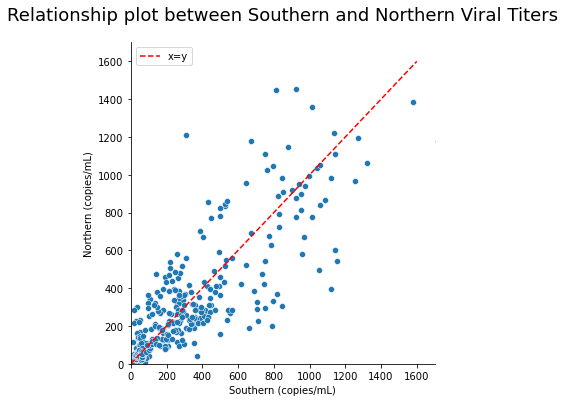

In [114]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

<ipython-input-115-aca315f587b7>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


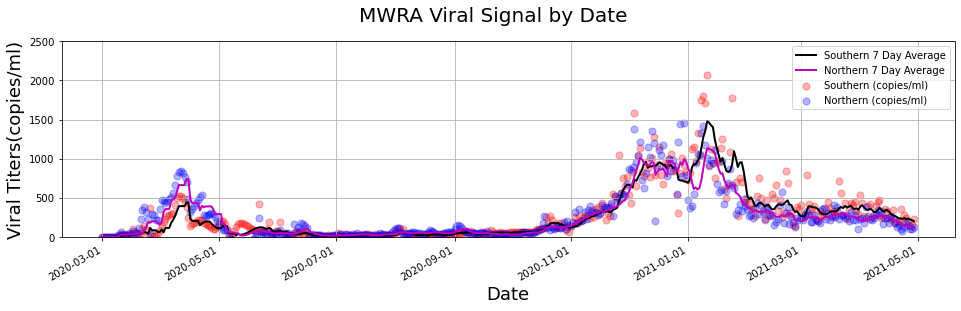

In [115]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [61]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [116]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

In [119]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [120]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


<ipython-input-121-e57cdb74b2b1>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


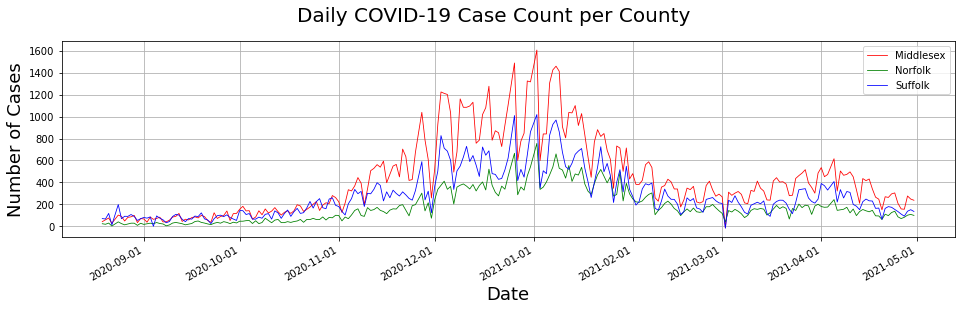

In [121]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [122]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135.0,16.0
1,2020-08-20,142.0,3.0
2,2020-08-21,221.0,3.0
3,2020-08-22,41.0,6.0
4,2020-08-24,340.0,13.0
...,...,...,...
245,2021-04-26,339.0,5.0
246,2021-04-27,329.0,1.0
247,2021-04-28,514.0,4.0
248,2021-04-29,507.0,5.0


<ipython-input-124-1396e3d9ed11>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


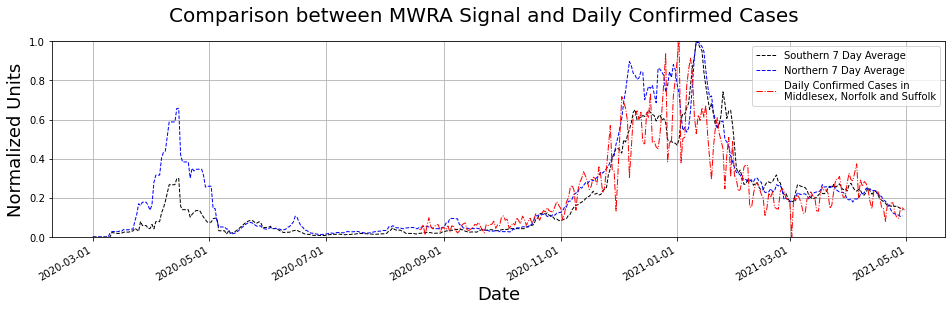

In [124]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [96]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern Raw', 'Northern Raw', 
                                              'Southern Avg', 'Northern Avg', 
                                                'Southern Variant', 'Northern Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Southern Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

,Date,Southern Raw,Northern Raw,Southern Avg,Northern Avg,Southern Variant,Northern Variant,Cases,Deaths
0,2020-08-19,0.013256,0.059959,0.000000,0.023636,0,0,0.038211,0.400
1,2020-08-20,0.000000,0.000000,0.000000,0.023636,0,0,0.040284,0.075
2,2020-08-21,0.009279,0.041351,0.004834,0.028182,0,0,0.063685,0.075
3,2020-08-22,0.000000,0.000000,0.004834,0.028182,0,0,0.010367,0.150
4,2020-08-24,0.005567,0.026189,0.003453,0.025455,0,0,0.098934,0.325
...,...,...,...,...,...,...,...,...,...
244,2021-04-25,0.063097,0.121296,0.138812,0.093636,63%,60%,0.125296,0.025
245,2021-04-26,0.055408,0.106134,0.142956,0.090909,64%,49%,0.098637,0.125
246,2021-04-27,0.036850,0.073742,0.134669,0.087273,59%,58%,0.095675,0.025
247,2021-04-28,0.041622,0.070296,0.129144,0.080000,0,0,0.150474,0.100


In [128]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [129]:
display(df_aligned.head())

,Date,Southern Raw,Northern Raw,Southern Avg,Northern Avg,Southern Variant,Northern Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50.0,87.0,28.0,56.0,0,0,135.0,16.0,5.561524,0.659144
1,2020-08-20,0.0,0.0,28.0,56.0,0,0,142.0,3.0,5.8499,0.123589
2,2020-08-21,35.0,60.0,35.0,61.0,0,0,221.0,3.0,9.104422,0.123589
3,2020-08-22,0.0,0.0,35.0,61.0,0,0,41.0,6.0,1.689056,0.247179
4,2020-08-24,21.0,38.0,33.0,58.0,0,0,340.0,13.0,14.006802,0.535554


Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

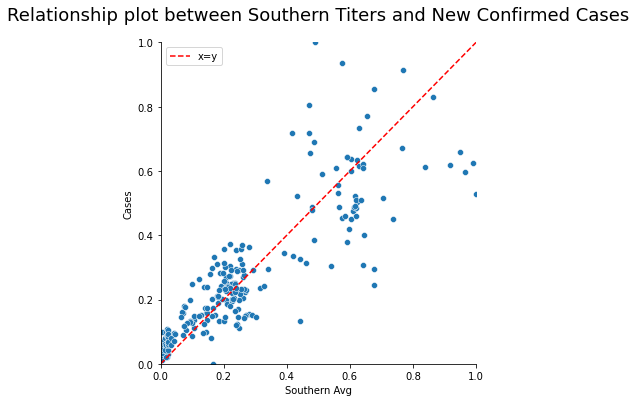

In [130]:
# Scale the values
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[['Southern Raw', 'Northern Raw','Southern Avg', 'Northern Avg','Cases', 'Deaths']] = scaler.fit_transform(df_aligned[['Southern Raw', 'Northern Raw', 
                                                                                                                    'Southern Avg', 'Northern Avg',
                                                                                                                           'Cases_per_100K', 'Deaths_per_100K']])
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Southern Avg", y="Cases")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)

<ipython-input-131-7231f6c99a59>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


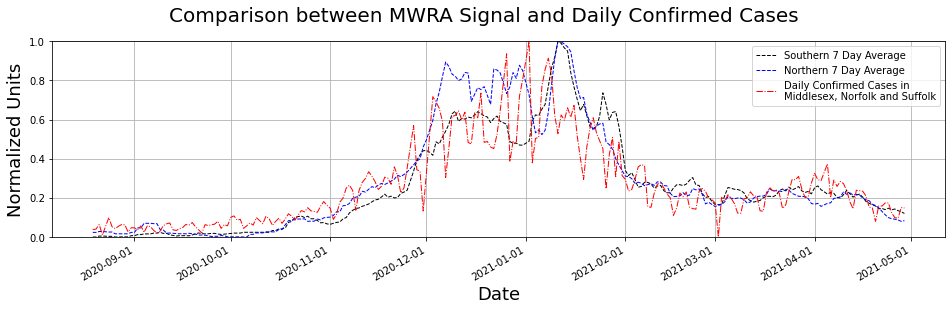

In [131]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [137]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths Avg'] = df_aligned['Deaths'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

<ipython-input-138-5c4df4d960ef>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


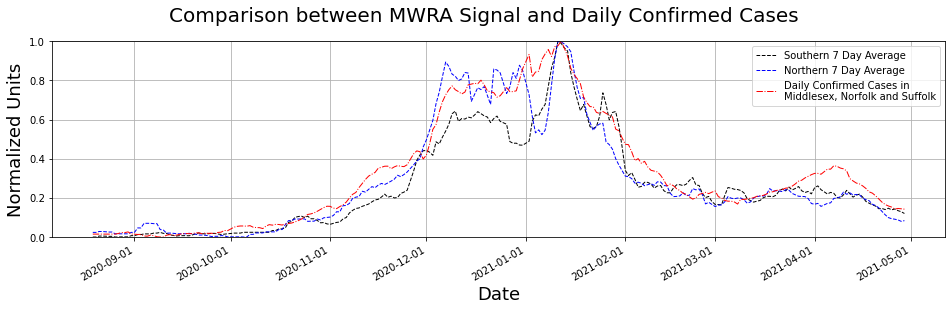

In [138]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases Avg'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

<ipython-input-139-b8f4cae3109a>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


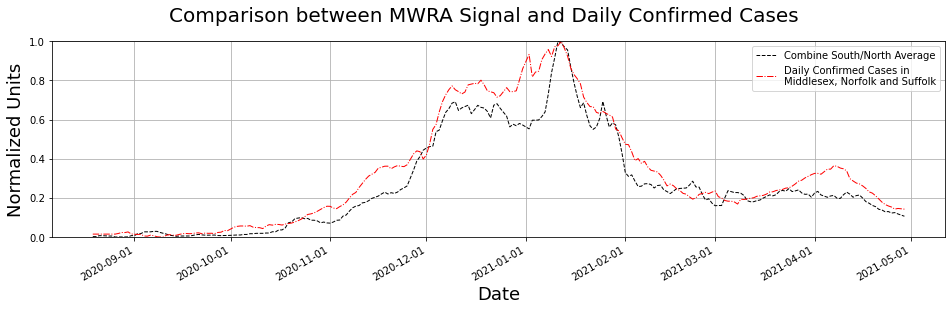

In [139]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
sn_combine = df_aligned['Southern Avg'] + df_aligned['Northern Avg'] / 2
ax.plot(df_aligned['Date'], normalize(sn_combine.to_numpy()), '--k', linewidth = 1,  label="Combine South/North Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases Avg'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

# Modeling


In [205]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


# Persistence Model

In [206]:
# Create lagged dataset
def persistence_values(x):
    x = pd.DataFrame(x)
    df = pd.concat([x.shift(1), x], axis=1)
    df.columns = ['x', 'y']
    return df

train = persistence_values(df_train['Cases'])
test = persistence_values(df_test['Cases'])

train_X, train_y = train.iloc[:,0], train.iloc[:,1]
test_X, test_y = test.iloc[:,0], test.iloc[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = [ model_persistence(x) for x in test_X ]
test_score = mean_squared_error(test_y[1:], predictions[1:])
print('Test MSE: %.3f' % test_score)

Test MSE: 37707.865


<ipython-input-230-489e3de8d1ef>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


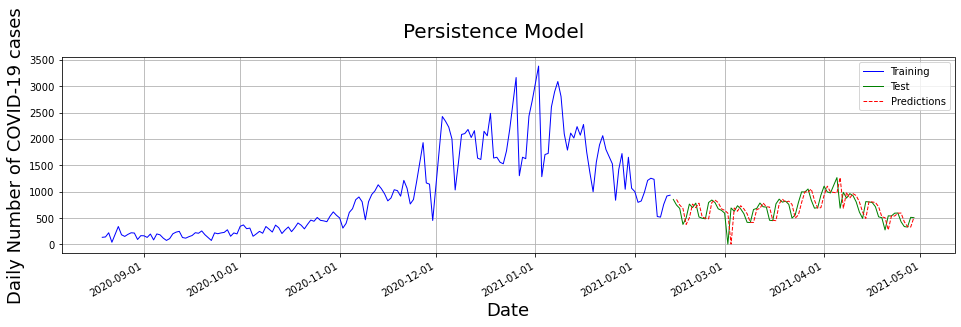

In [230]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
ax.plot(df_test['Date'], predictions, '--r', linewidth = 1,  label="Predictions")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Daily Number of COVID-19 cases', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Persistence Model', fontsize=20, y=1.00)
fig.show()

In [196]:
# Linear Regression Model
X = df_train[['Southern Raw', 'Northern Raw']].astype('float')
y = df_train['Cases'].astype('float')

X = sm.add_constant(X) # adding a constant
model_lm1 = sm.OLS(y, X).fit()

# Print summary
model_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     252.8
Date:                Sun, 02 May 2021   Prob (F-statistic):           8.47e-52
Time:                        00:06:02   Log-Likelihood:                -1291.7
No. Observations:                 174   AIC:                             2589.
Df Residuals:                     171   BIC:                             2599.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          272.0049     44.063      6.173      0.000     185.028     358.982
Southern Raw     0.3347      0.095      3.521      0.001       0.147       0.522
Northern Raw     1.3787      0.122     11.277      0.000       1.137       1.620
==============================================================================
Omnibus:                       82.833   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              636.831
Skew:                           1.560   Prob(JB):                    5.17e-139
Kurtosis:                      11.838   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Linear Regression

In [213]:
train_preds = model_lm1.get_prediction(X).summary_frame()

X_test = df_test[['Southern Raw', 'Northern Raw']].astype('float')
X_test = sm.add_constant(X_test) # adding a constant
test_preds = model_lm1.get_prediction(X_test).summary_frame()

<ipython-input-229-388f46852f16>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


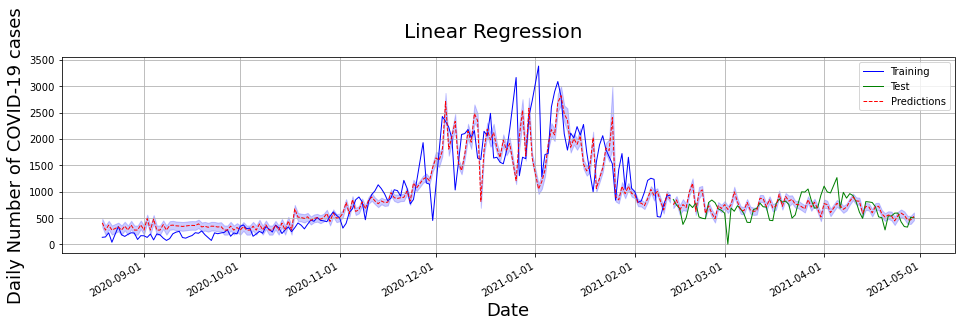

In [229]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                train_preds['mean_ci_upper'], color='b', alpha=.2)

ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Daily Number of COVID-19 cases', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Linear Regression', fontsize=20, y=1.00)
fig.show()

# Polynomal Regression

In [234]:
def generate_poly_features(x, degree):
    poly = PolynomialFeatures(degree=degree)
    xp = poly.fit_transform(x)
    return xp

def generate_polynomial_model(x, y, degree):
    xp = generate_poly_features(x, degree)
    return xp, sm.OLS(y, xp).fit()

<ipython-input-242-ca2f7d8056a5>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


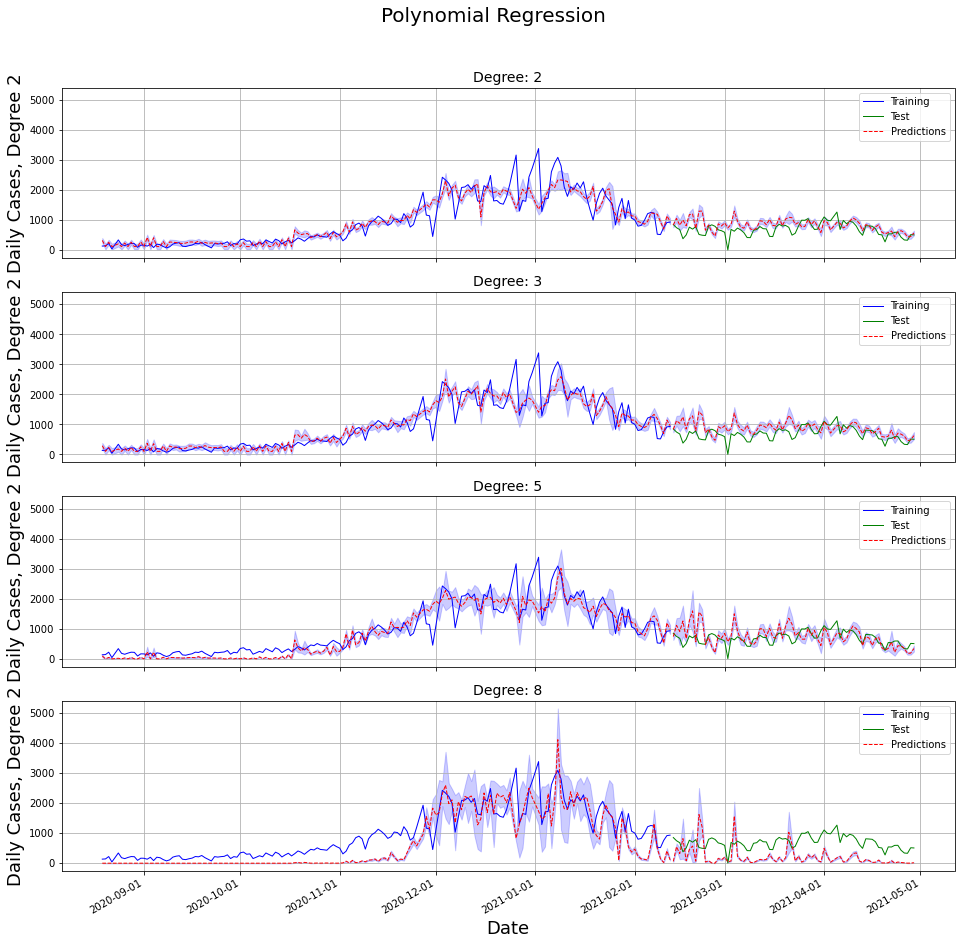

In [242]:
#your code here
poly_models = list()
degrees = [2,3,5,8]

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 4, ncols = 1, sharey=True, figsize=(16,16))
ax = ax.flatten()

X = df_train[['Southern Raw', 'Northern Raw']].astype('float')
y = df_train['Cases'].astype('float')
    
for i, (model, degree) in enumerate(zip(models, degrees)):

    # Generate model
    X_train , model = generate_polynomial_model(X, y, degree)
    
    # Add model to list
    poly_models.append(model)
    
    # Generate x_test
    X_test = generate_poly_features(df_test[['Southern Raw', 'Northern Raw']].astype('float'), degree)
    
    # Generate predictions
    train_preds = model.get_prediction(X_train).summary_frame()
    test_preds = model.get_prediction(X_test).summary_frame()
    
    ax[i].plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
    ax[i].plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
    ax[i].plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
    ax[i].plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

    # CI for the predection at each x value, i.e. the line itself
    ax[i].fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                    train_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                    test_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].grid(True)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_title(f'Degree: {degree}', fontsize=14)
    ax[i].set_ylabel(f'Daily Cases', fontsize = 18)
    ax[i].set_xlabel('Date', fontsize = 18)

    
fig.autofmt_xdate()
fig.suptitle('Polynomial Regression', fontsize=20, y=0.95)
fig.show()